In [1]:
!pip install tensorflow
!pip install scikit-learn

In [22]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import os
import cv2  # OpenCV for image loading
import zipfile

In [70]:
ZIP_FILE_NAME = "handwritten answers dataset.zip" 
ORIGINAL_ANSWERS_DIR = "handwritten answers dataset/original answers/with questions"
AI_ANSWERS_DIR = "handwritten answers dataset/ai generated answers/with questions"
IMG_SIZE = 128
BATCH_SIZE = 16 # Smaller batch size for a small dataset
EPOCHS = 30

In [37]:
# Data Loading Function
def load_images_from_folders(zip_file_path):
    images = []
    labels = []
    
    try:
        with zipfile.ZipFile(zip_file_path, 'r') as zf:
            # Getting all file names in the zip
            all_files = zf.namelist()
            
            # Processing ORIGINAL images (Label 0)
            original_files = [f for f in all_files if f.startswith(ORIGINAL_ANSWERS_DIR) and f.lower().endswith(('.jpg', '.jpeg', '.png'))]
            for file_path in original_files:
                try:
                    with zf.open(file_path) as f:
                        file_bytes = np.frombuffer(f.read(), np.uint8)
                        img = cv2.imdecode(file_bytes, cv2.IMREAD_GRAYSCALE) # Read as grayscale
                        img_resized = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
                        images.append(img_resized)
                        labels.append(0) # 0 for Original
                except Exception as e:
                    print(f"Error loading {file_path}: {e}")

            # Processing AI-GENERATED images (Label 1)
            ai_files = [f for f in all_files if f.startswith(AI_ANSWERS_DIR) and f.lower().endswith(('.jpg', '.jpeg', '.png'))]
            for file_path in ai_files:
                try:
                    with zf.open(file_path) as f:
                        file_bytes = np.frombuffer(f.read(), np.uint8)
                        img = cv2.imdecode(file_bytes, cv2.IMREAD_GRAYSCALE)
                        img_resized = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
                        images.append(img_resized)
                        labels.append(1) # 1 for AI-Generated
                except Exception as e:
                    print(f"Error loading {file_path}: {e}")

    except FileNotFoundError:
        print(f"Error: ZIP file '{ZIP_FILE_NAME}' not found. Please upload your dataset.")
        return None, None, None
    except Exception as e:
        print(f"An error occurred opening the zip file: {e}")
        return None, None, None

    # Converting lists to numpy arrays
    images = np.array(images)
    labels = np.array(labels)
    
    # Normalizing and reshape images for the CNN
    images = images.astype('float32') / 255.0
    images = images.reshape(-1, IMG_SIZE, IMG_SIZE, 1) # Reshaping for grayscale CNN
    
    # One-hot encode labels
    labels_categorical = to_categorical(labels, num_classes=2)
    
    return images, labels_categorical, labels

In [38]:
# Loading and Spliting Data
try:
    X, y_categorical, y_labels = load_images_from_folders(ZIP_FILE_NAME)
    
    if X is not None and len(X) > 0:
        print(f"Data loaded: {len(X)} images ({np.sum(y_labels == 0)} Original, {np.sum(y_labels == 1)} AI-Generated)")

        # Spliting the data into training and validation sets
        X_train, X_val, Y_train, Y_val = train_test_split(X, y_categorical, test_size=0.2, random_state=42, stratify=y_labels)
        
        print(f"Training data shape: {X_train.shape}")
        print(f"Validation data shape: {X_val.shape}")
    else:
        print("Data loading failed. Cannot proceed.")
        X_train = []

except Exception as e:
    print(f"An error occurred during data loading: {e}")
    X_train = []

Data loaded: 34 images (17 Original, 17 AI-Generated)
Training data shape: (27, 128, 128, 1)
Validation data shape: (7, 128, 128, 1)


In [39]:
# Data Augmentation
if len(X_train) > 0:
    datagen = ImageDataGenerator(
        rotation_range=15,        # Slightly more rotation
        zoom_range = 0.15,        # Slightly more zoom
        width_shift_range=0.1,    
        height_shift_range=0.1,
        shear_range=0.1,
        horizontal_flip=False     # Usually not for text
    )

    datagen.fit(X_train)
    print("Data augmentation generator created.")
else:
    print("Skipping data augmentation setup (no data).")

Data augmentation generator created.


In [62]:
# Building the CNN Model
if len(X_train) > 0:
    model = Sequential()
    model.add(Input(shape=(IMG_SIZE, IMG_SIZE, 1))) 
    model.add(Conv2D(32, kernel_size=(3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(2, activation='softmax')) # 2 classes (Original, AI)

    model.summary()

    # Compiling the model
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    print("Model built and compiled.")
else:
    print("Skipping model build (no data).")

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_12 (Conv2D)                   │ (None, 126, 126, 32)        │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_12 (MaxPooling2D)      │ (None, 63, 63, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_13 (Conv2D)                   │ (None, 61, 61, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_13 (MaxPooling2D)      │ (None, 30, 30, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_6 (Flatten)                  │ (None, 57600)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 128)                 │       7,372,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ (None, 2)                   │             258 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 7,392,002 (28.20 MB)

 Trainable params: 7,392,002 (28.20 MB)

 Non-trainable params: 0 (0.00 B)

Model built and compiled.


In [66]:
# Training the Model
if len(X_train) > 0:
    steps_per_epoch = len(X_train) // BATCH_SIZE
    if steps_per_epoch == 0:
        steps_per_epoch = 1

    train_generator = datagen.flow(X_train, Y_train, batch_size=BATCH_SIZE)

    print("Starting model training...")
    history = model.fit(train_generator,
                        epochs=EPOCHS,
                        verbose=1,
                        validation_data=(X_val, Y_val),
                        steps_per_epoch=steps_per_epoch)
    print("Model training complete.")
else:
    print("Skipping model training (no data).")

Starting model training...
Epoch 1/30


D:\Python\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 420ms/step - accuracy: 0.6250 - loss: 0.6529 - val_accuracy: 0.5714 - val_loss: 0.6711
Epoch 2/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 258ms/step - accuracy: 0.5455 - loss: 0.6727 - val_accuracy: 0.5714 - val_loss: 0.6734
Epoch 3/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 366ms/step - accuracy: 0.5455 - loss: 0.6551 - val_accuracy: 0.4286 - val_loss: 0.6796
Epoch 4/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 309ms/step - accuracy: 0.8125 - loss: 0.6473 - val_accuracy: 0.7143 - val_loss: 0.6800
Epoch 5/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 353ms/step - accuracy: 0.7500 - loss: 0.6502 - val_accuracy: 0.4286 - val_loss: 0.6749
Epoch 6/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 260ms/step - accuracy: 0.7273 - loss: 0.6294 - val_accuracy: 0.7143 - val_loss: 0.6746
Epoch 7/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 324ms/step - accuracy: 0.6250 - loss: 0.6333 - val_accuracy: 0.4286 - val_loss: 0.6646
Epoch 8/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 275ms/step - accuracy: 0.7273 - loss: 0.6345 - val_accuracy: 0.5714 - val_loss: 0.6829
Epo

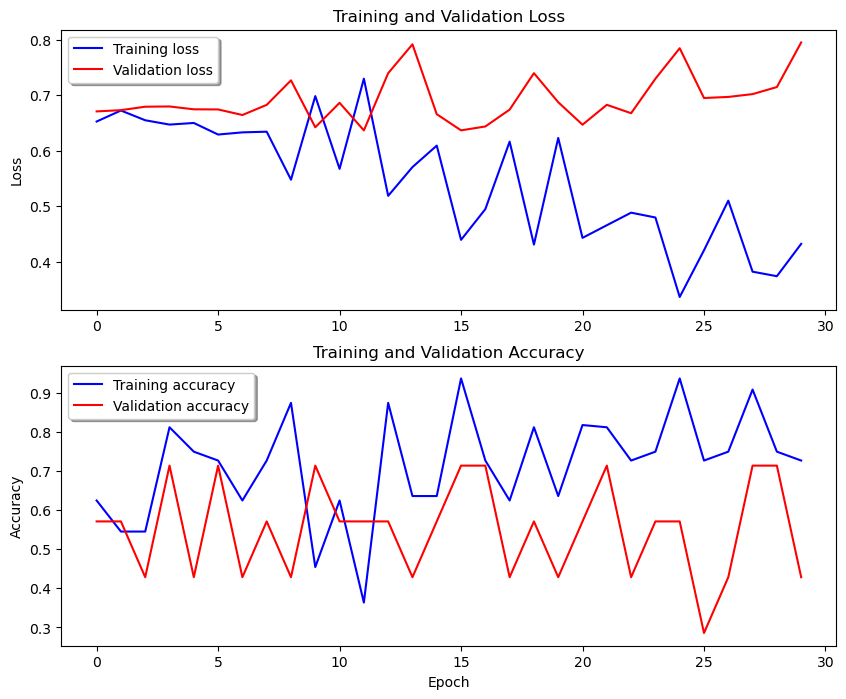

In [67]:
# Plotting Training & Validation History
if 'history' in locals():
    fig, ax = plt.subplots(2,1, figsize=(10, 8))
    
    # Plotting Loss
    ax[0].plot(history.history['loss'], color='b', label="Training loss")
    ax[0].plot(history.history['val_loss'], color='r', label="Validation loss")
    ax[0].legend(loc='best', shadow=True)
    ax[0].set_ylabel('Loss')
    ax[0].set_title('Training and Validation Loss')

    # Plotting Accuracy
    ax[1].plot(history.history['accuracy'], color='b', label="Training accuracy")
    ax[1].plot(history.history['val_accuracy'], color='r',label="Validation accuracy")
    ax[1].legend(loc='best', shadow=True)
    ax[1].set_ylabel('Accuracy')
    ax[1].set_xlabel('Epoch')
    ax[1].set_title('Training and Validation Accuracy')

    plt.savefig("training_history.png")
    plt.show()
else:
    print("Skipping history plot (model not trained).")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


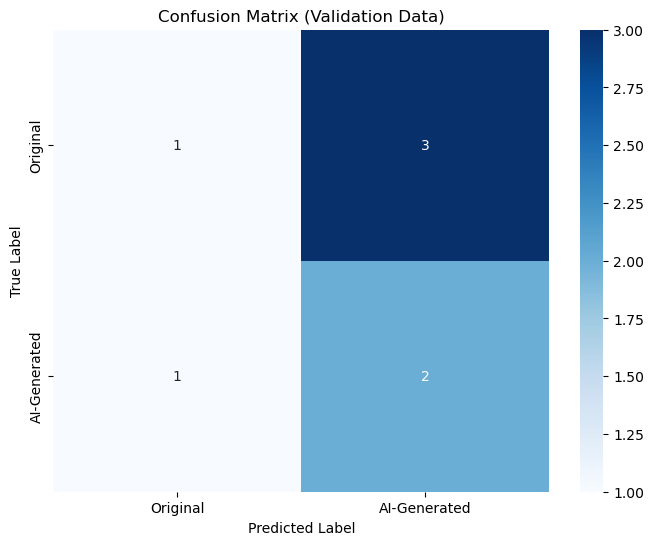

In [68]:
# --- 8. Confusion Matrix ---
if 'history' in locals():
    # Get predictions on the validation set
    Y_pred_val = model.predict(X_val)
    Y_pred_val_classes = np.argmax(Y_pred_val, axis=1) # Predicted class index (0 or 1)
    Y_true_val = np.argmax(Y_val, axis=1) # True class index (0 or 1)

    # Generate the confusion matrix
    confusion_mtx = confusion_matrix(Y_true_val, Y_pred_val_classes)

    # Plotting the confusion matrix
    plt.figure(figsize=(8, 6))
    class_names = ['Original', 'AI-Generated']
    sns.heatmap(confusion_mtx, annot=True, fmt='d', cmap='Blues', 
                xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix (Validation Data)')
    plt.savefig("confusion_matrix.png")
    plt.show()
else:
    print("Skipping confusion matrix (model not trained).")

In [69]:
# Full Detailed Report
if 'history' in locals():
    # Getting final scores
    final_train_acc = history.history['accuracy'][-1]
    final_val_acc = history.history['val_accuracy'][-1]
    final_train_loss = history.history['loss'][-1]
    final_val_loss = history.history['val_loss'][-1]

    print("="*60)
    print("            DETAILED CNN CLASSIFICATION REPORT")
    print("="*60)
    print("\n")

    print("--- 1. DATASET DETAILS ---")
    print(f"Dataset Used:         Handwritten Answer Scripts")
    print(f"Total Images Loaded:  {len(X)}")
    print(f"Class 0 (Original):   {np.sum(y_labels == 0)} images")
    print(f"Class 1 (AI-Gen):     {np.sum(y_labels == 1)} images")
    print("\n")

    print("--- 2. DATA SPLIT ---")
    print(f"Total Training Data:    {len(X_train)} images")
    print(f"Total Validation Data:  {len(X_val)} images")
    print("\n")

    print("--- 3. MODEL & TRAINING PARAMETERS ---")
    print(f"Model Task:             Binary Classification (Original vs. AI)")
    print(f"Input Image Size:       {IMG_SIZE}x{IMG_SIZE} (Grayscale)")
    print(f"Optimizer:              adam")
    print(f"Loss Function:          categorical_crossentropy")
    print(f"Training Epochs:        {EPOCHS}")
    print(f"Batch Size:             {BATCH_SIZE}")
    print("\n")

    print("--- 4. MODEL PERFORMANCE (FINAL EPOCH) ---")
    print(f"Final Training Accuracy:   {final_train_acc:.4f} (or {final_train_acc*100:.2f}%)")
    print(f"Final Validation Accuracy: {final_val_acc:.4f} (or {final_val_acc*100:.2f}%)")
    print(f"Final Training Loss:       {final_train_loss:.4f} (or {final_train_loss*100:.2f}%)")
    print(f"Final Validation Loss:     {final_val_loss:.4f} (or {final_val_loss*100:.2f}%)")
    print("\n")
    
    print("--- 5. VALIDATION CLASSIFICATION REPORT ---")
    class_names = ['Original', 'AI-Generated']
    print(classification_report(Y_true_val, Y_pred_val_classes, target_names=class_names))
    print("\n")

    print("="*60)
    print("                     END OF REPORT")
    print("="*60)
else:
    print("Skipping final report (model not trained).")

            DETAILED CNN CLASSIFICATION REPORT


--- 1. DATASET DETAILS ---
Dataset Used:         Handwritten Answer Scripts
Total Images Loaded:  34
Class 0 (Original):   17 images
Class 1 (AI-Gen):     17 images


--- 2. DATA SPLIT ---
Total Training Data:    27 images
Total Validation Data:  7 images


--- 3. MODEL & TRAINING PARAMETERS ---
Model Task:             Binary Classification (Original vs. AI)
Input Image Size:       128x128 (Grayscale)
Optimizer:              adam
Loss Function:          categorical_crossentropy
Training Epochs:        30
Batch Size:             16


--- 4. MODEL PERFORMANCE (FINAL EPOCH) ---
Final Training Accuracy:   0.7273 (or 72.73%)
Final Validation Accuracy: 0.4286 (or 42.86%)
Final Training Loss:       0.4322 (or 43.22%)
Final Validation Loss:     0.7954 (or 79.54%)


--- 5. VALIDATION CLASSIFICATION REPORT ---
              precision    recall  f1-score   support

    Original       0.50      0.25      0.33         4
AI-Generated       0.40      0